## Detecting Fake News
#### Arhum Zafar - November 2020

**This was written prior to the 2020 General Election*

Table of Contents

### Introduction

It's obvious that the internet has made accessing information easy to all around the world. Unfortunately, the internet has slowly turned into a hub of misinformation, or what many would call, "fake news". The problem arises when misinformation falls into the minds of wrong people, who are then convinced or persuaded to act out on the false narratives that they've heard; this can be proven by the fact of how many riots and killings have taken place in the past year. 
<br>
<br>
Fake news can even sway people's opinions and affiliations - a fact that political parties have used (and still use) to make people vote in their favour. This enhances the need to find the ability to seperate what's real from what's not. For many, doing such a thing is a difficult task -- in this notebook, I use machine learning, specifically Natural Language Processing (NLP) to classify what's fake apart from the real news.

<br>
<br>
The dataset used exists as a train and test file. For obvious reasons, we'll holdout the test set until the model is ready to go.

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import itertools
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

#### Load Dataset

In [17]:
data = pd.read_csv("train.csv")
data.head(10)
#data.shape

,index,title,text,subject,date,class,Unnamed: 6
0,0,PRESIDENT TRUMP Explains New “America First” R...,That s what we re talking about! Another campa...,politics,"Aug 2, 2017",Fake,NaN
1,1,TERMINALLY ILL FORMER MISS WI: “Until my last ...,How is it that Sean Hannity is the only media ...,politics,"Oct 4, 2016",Fake,NaN
2,2,Cruz Humiliated By Moderator After Lie About ...,Almost immediately after learning that longtim...,News,"February 13, 2016",Fake,NaN
3,3,"Russia revels in Trump victory, looks to sanct...",MOSCOW (Reuters) - For all their mutual praise...,politicsNews,"November 9, 2016",Real,NaN
4,4,Trump's bid to open U.S. monuments to developm...,WASHINGTON (Reuters) - The Trump administratio...,politicsNews,"May 26, 2017",Real,NaN
5,5,UNREAL! HERE’S WHY ICE RELEASED BUT DIDN’T DEP...,THANK GOODNESS FOR THE CENTER FOR IMMIGRATION ...,Government News,"Apr 28, 2016",Fake,NaN
6,6,CONSEQUENCES OF LIBERAL TOLERANCE: He Had An I...,Terrified concert goers fled an Ariana Grande ...,politics,"May 25, 2017",Fake,NaN
7,7,U.S. NEWS and WORLD REPORT Publishes List Of T...,"More than 21,000 people from all regions of th...",politics,"Jul 13, 2017",Fake,NaN
8,8,Trump administration's NAFTA demands make sens...,DETROIT (Reuters) - The list of priorities U.S...,politicsNews,"July 20, 2017",Real,NaN
9,9,Turks flock to social media for gold trader sa...,ANKARA (Reuters) - Allegations of wrongdoing b...,worldnews,"December 1, 2017",Real,NaN


In [18]:
# Check for nulls
data.isnull().sum()

index             0
title             0
text              0
subject           0
date              0
class             0
Unnamed: 6    39999
dtype: int64

In [19]:
# Is out dataset imbalanced?
data["class"].value_counts()

Fake                20886
Real                19113
February 5, 2017        1
Name: class, dtype: int64

So far, I can point out two things:
<br>
1) Our dataset is somewhat balanced, with the # of "real" and "fake" classes almost being equal. <br>
2) There is a feature titled "February 5, 2017", which is different than the real and fake classes that we are looking for. I can remove this point, or shift it into the next column -- which is shown below.

In [20]:
data[data['class'] == "February 5, 2017"]

,index,title,text,subject,date,class,Unnamed: 6
504,504,Even Mitch McConnell Is Beginning To Turn On ...,Is Impeachment Next? (VIDEO),Donald Trump s Muslim ban is proving to be a l...,News,"February 5, 2017",Fake


In [21]:
# take above index and shift column values to corresponding places

data.iloc[504, 2] = data.iloc[504, 3]
data.iloc[504, 3] = data.iloc[504, 4]
data.iloc[504, 4] = data.iloc[504, 5]
data.iloc[504, 5] = data.iloc[504, 6]
data.iloc[504, 6] = np.nan

In [22]:
data.iloc[[504]]

,index,title,text,subject,date,class,Unnamed: 6
504,504,Even Mitch McConnell Is Beginning To Turn On ...,Donald Trump s Muslim ban is proving to be a l...,News,"February 5, 2017",Fake,NaN


Now that **index** and **Unnamed: 6** have become redundant, I'll go ahead and delete them.

In [23]:
data.drop(["index", "Unnamed: 6"], axis = 1, inplace = True)
data.head(3)

,title,text,subject,date,class
0,PRESIDENT TRUMP Explains New “America First” R...,That s what we re talking about! Another campa...,politics,"Aug 2, 2017",Fake
1,TERMINALLY ILL FORMER MISS WI: “Until my last ...,How is it that Sean Hannity is the only media ...,politics,"Oct 4, 2016",Fake
2,Cruz Humiliated By Moderator After Lie About ...,Almost immediately after learning that longtim...,News,"February 13, 2016",Fake


### Data

Now that the dataframe has been cleaned up, let's take a quick look at it.

In [26]:
data.describe(include = 'all').T

,count,unique,top,freq
title,40000,35075,Factbox: Trump fills top jobs for his administ...,12
text,40000,34965,,552
subject,40000,8,politicsNews,10075
date,40000,2388,"December 20, 2017",161
class,40000,2,Fake,20887


By looking above, there are 40,000 titles and texts -- with 35,075 and 34,965 unique ones, respectively. Let's now focus on removing the non-unique ones. There are more *non-unique* entries than there are for title.

In [28]:
data.drop_duplicates(subset = ['text'], inplace=True)
data.reset_index(drop = True, inplace = True)
data.describe(include = 'all').T

,count,unique,top,freq
title,34965,34653,Factbox: Trump fills top jobs for his administ...,12
text,34965,34965,WASHINGTON (Reuters) - Congressional intellige...,1
subject,34965,8,politicsNews,10023
date,34965,2388,"December 6, 2017",149
class,34965,2,Real,18936


Now, there are 34,653 unique texts. This will suffice for analysis.
<br>
<br>
Let's look at our data.

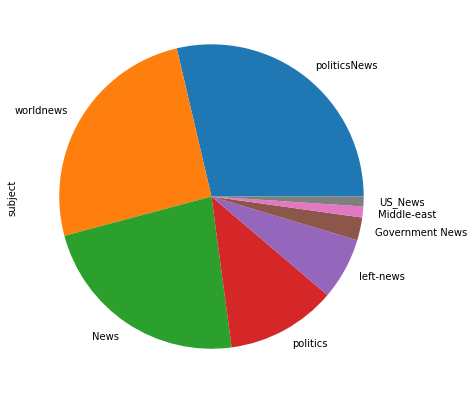

In [29]:
data['subject'].value_counts().plot.pie(figsize = (7,7))

### What are Stopwords?